# Transformers for BoolQ reading comprehension
*All changes and additions compared to Stage 1 are marked in <span style="color: orange;">orange</span>*

## Sources

My sources for this project are linked in the respecting sections of the notebook. I used AI tools such as ChatGPT to correct my writing and grammar in stage 1 of this project and plan on using it for debugging during stage 2.

## <span style="color: orange;">TLDR - Executive summary</span>
### **Topic:**
Develop and train a Transformer-based model end to end for binary question answering on the BoolQ dataset from Huggin Face.

### **Data:**
The dataset is for reading comprehension and question answering tasks. It consists of questions, passages and the corresponding yes/no answers, with seperate training and test splits. Splitting the last 1000 entries of the training split to use as a validation split in this project.

### **Methods:**
The project involves preprocessing the data using the AutoTokenizer with the pre-trained "bert-base-cased" model. Then transforming the token IDs to word embeddings using the nn.Embedding layer. Using projection layer in between we reach the transformerEncoder with six layers followed by the mean pooling layer for dimensionality reduction into the 2-layer classifier from which we finally receive the binary output.

### **Model:**
The model is based on a PyTorch implementation of a Transformer Encoder, structured as follows:
- Embedding Layer: nn.Embedding layer to map tokens to embeddings.
- Positional Embedding Layer: Adds positional information to embeddings.
- Linear Projection Layer: Projects from embedding dimension to transformer hidden dimension.
- Transformer Encoder: A 6-layer transformer encoder block.
- Pooling Layer: Mean pooling for dimensionality reduction.
- Classifier: A 2-layer classifier with ReLU non-linearity.
- Loss Function: Cross-Entropy Loss.

### **Experiments:**
Link to WandB: [Weights and Biases]() <br>
17 manual experiments were conducted, exploring combinations of transformer (from 128 to 1024) and classifier hidden dimensions (from 64 to 512) as well as embedding dimensions (from 128 to 512) as well as further adjustments mentioned in more detail in the model section of the notebook.

### **Results:**
Key findings:
- Adding 100 warmup steps at a batch size of 64 improved performance compared to no warmup.
- A dropout rate of 0.2 was introduced to reduce overfitting on the training set.
- After facing some issues with optuna for automatic hyperparameter tuning, manual tuning resulted in a model barely outperforming the majority baseline test accuracy of 62.17% with a test accuracy of **63.70%**.



## Setup

**Importing Python Packages**
Making sure the notebook is reproducible and runs without error, I will install the necessary libraries in a pip cell below.

**Data Loading and Split**
The data consists of the questions, a passage and the answer. In total there are 12'697 entries in the dataset. Splitting them according to the lecture slides into train (8427), validation (1000) and test (3270).

**Seeding for Reproducibility**
Setting the random Seed to 42 for reproducibility.

In [3]:
# TODO: make the pip install for used libraries and packages !!!
%pip install -q wandb datasets torch transformers pytorch_lightning torchmetrics matplotlib seaborn scikit-learn 

Note: you may need to restart the kernel to use updated packages.


In [4]:
import wandb

from datasets import load_dataset

import torch
import torch.nn as nn

from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

from pathlib import Path
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
pl.seed_everything(42, workers=True)

Seed set to 42


42

In [7]:
BATCH_SIZE = 64

In [8]:
# Loading the dataset based on lecture slides
train_data = load_dataset('google/boolq', split='train[:-1000]')
validation_data = load_dataset('google/boolq', split='train[-1000:]')
test_data = load_dataset('google/boolq', split='validation')

In [9]:
test_question = train_data[5]['question']
test_passage = train_data[5]['passage']
print(train_data[5])
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(validation_data)}")
print(f"Number of validation samples: {len(test_data)}")

train_yes_count = sum(1 for label in train_data['answer'] if label == 1)
train_no_count = sum(1 for label in train_data['answer'] if label == 0)
train_total = train_yes_count + train_no_count

validation_yes_count = sum(1 for label in validation_data['answer'] if label == 1)
validation_no_count = sum(1 for label in validation_data['answer'] if label == 0)
validation_total = validation_yes_count + validation_no_count

test_yes_count = sum(1 for label in test_data['answer'] if label == 1)
test_no_count = sum(1 for label in test_data['answer'] if label == 0)
test_total = test_yes_count + test_no_count

print(f"Train set (yes/no) Ratio: {round(train_yes_count / train_no_count, 2)}, Percent Yes: {round(train_yes_count / train_total * 100, 2)}%")

print(f"Validation set (yes/no) Ratio: {round(validation_yes_count / validation_no_count, 2)}, Percent Yes: {round(validation_yes_count / validation_total * 100, 2)}%")

print(f"Test set (yes/no) Ratio: {round(test_yes_count / test_no_count, 2)}, Percent Yes: {round(test_yes_count / test_total * 100, 2)}%")

{'question': 'can you use oyster card at epsom station', 'answer': False, 'passage': "Epsom railway station serves the town of Epsom in Surrey. It is located off Waterloo Road and is less than two minutes' walk from the High Street. It is not in the London Oyster card zone unlike Epsom Downs or Tattenham Corner stations. The station building was replaced in 2012/2013 with a new building with apartments above the station (see end of article)."}
Number of training samples: 8427
Number of validation samples: 1000
Number of validation samples: 3270
Train set (yes/no) Ratio: 1.68, Percent Yes: 62.64%
Validation set (yes/no) Ratio: 1.47, Percent Yes: 59.5%
Test set (yes/no) Ratio: 1.64, Percent Yes: 62.17%


## Preprocessing
### Tokenizer
In past projects I always did some sort of manual preprocessing of the data. In this project I deliberately refrain from any manual preprocessing and will let the built-in features of the AutoTokenizer with the from_pretrained("bert-base-cased") model handle the following steps for me:
- Whitespace and Special Character removal (e.g. emojis or phonetic pronunciations)
- Case Sensitivity
- Padding and Truncation (pad automatically, truncate to max: 512 tokens - amount of pretrained position embeddings)

I only now found out about this from the Hugging Face Transformer [Preprocessing Data Documentation](https://huggingface.co/transformers/v3.0.2/preprocessing.html).

### Lowercase / Case Sensitivity
From my feedback I will now keep case sensitivity instead of lower-casing all text. Example of case sensitivity: the word "US" would become "us" and could thus change the meaning of a sentence drastically. <br>
*Source*: Feedback from Project 2 (LSTM)

### Padding / Truncation
I rely on the built-in padding and truncation functions of the AutoTokenizer from Hugging Face to manage sequence lengths efficiently:
- Questions are limited to a maximum of 21 tokens, based on the length of the longest question in the dataset.
- Passages are padded to a maximum of 488 tokens, ensuring that when the question (21 tokens), start token, end token, and separator token are included, the total length remains within the 512-token limit supported by the Transformer’s positional embeddings.

### Stemming / Lemmatization / Stopword removal
From a past lecture I took away that stemming or lemmatization is not the right choice for a reading comprehension task. It removes valuable meaning
No stemming or lemmatization will be done in my preprocessing as to keep the most amount of information possible in my sequences. Stopwords will also not be removed for the same reason.

### Embedding Layer
In this project, the embedding layer is implemented using PyTorch's nn.Embedding class. The embeddings are trained end-to-end alongside the rest of the model, allowing them to adapt to the specific nuances of the BoolQ dataset.
- **Vocabulary Size**: Determined by the tokenizer
- **Embedding Dimension**: Set to 300 as this is widely used by large pretrained embedding models like fastText or word2vec.
- **Training**: Initialized randomly and updated during training through backpropagation.

### Absolute Position Embeddings
Since the nn.TransformerEncoder does not by default have positional embeddings I will be implementing them through absolute position embeddings. Choosing the embeddings over the encoding because it is more widely used in practice.
Adding the learned absolute positional embeddings to the word embeddings before feeding the input into the transformer model. The position embeddings are initialized randomly and are trained with the model through backpropagation.
*Source*: Lecutre on positional encodings

### Input / Output / Label format
Each data point in the dataset is made up of a questions, passage and the respective binary label. The preprocessing steps transform these into the following formats for my model inputs:
- Embedding Layer:
    - *input*: Tensor of (batch_size, sequence_length) containing token IDs.
    - *output*: Tensor for (batch_size, sequence_length, embedding_dim) with each token ID mapped to a dense vector of size embedding_dim.

- 6-Layer Transformer Encoder:
    - *input*: The embeddings with shape (batch_size, sequence_length, embedding_dim).
    - *output*: A Tensor of shape (batch_size, sequence_length, embedding_dim).

- Pooling Layer:
    - *input*: The output of the last transformer layer, with shape (batch_size, sequence_length, embedding_dim)
    - *output*: A Tensor of shape (batch_size, embedding_dim), representing the aggregated sequence information.

- 2-Layer Classifier:
    - *input*: The pooled output, with shape (batch_size, embedding_dim)
    - *output*: A tensor of shape (batch_size, hidden_dim) for the first layer and shape (batch_size, num_classes) for the final layer.

- Label format:
    - The labels will be encoded as boolean values, enabling the model to predict either 0 or 1 (False/True).

In [10]:
# initialize tokenizer with bert-base-cased model

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
VOCAB_SIZE = tokenizer.vocab_size


def get_max_question_len(dataset):
    max_len = 0
    for item in dataset:
        question = item['question']
        tokenized_question = tokenizer.encode(question)
        max_len = max(max_len, len(tokenized_question))
    return max_len

max_question_len = get_max_question_len(train_data)
print(max_question_len) # max len of BPE tokenized question (including the CLS and SEP tokens) 


29


In [11]:
def tokenize_batch(batch):
    questions = batch['question']
    passages = batch['passage']
    
    encodings = tokenizer(
        questions,
        passages,
        max_length=512,  # Combined max length within Transformer limit
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    
    return {'input_ids': encodings['input_ids'], 'labels': torch.tensor(batch['answer'])}  # output of input_ids and labels

In [12]:
# Tokenize the datasets
train_data = train_data.map(tokenize_batch, batched=True).with_format("torch", device=DEVICE)
validation_data = validation_data.map(tokenize_batch, batched=True).with_format("torch", device=DEVICE)
test_data = test_data.map(tokenize_batch, batched=True).with_format("torch", device=DEVICE)

In [13]:
# Define collate function for dynamic padding in DataLoader
def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    labels = torch.tensor([item['labels'] for item in batch])
    
    # Pad to the longest sequence in the batch
    input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True)
    return {'input_ids': input_ids, 'labels': labels}

## Model
### Architecture
- **Input Layer**:
    - The input to my model is the nn.Embedding layer that will be trained on the dataset with the network.
    - Each input sequence consists of a concatenated question and passage with a [SEP] token between them, marking the boundary. The separator token allows the model to distinguish between the two segments.
    - The resulting shape of the input tensor after embedding is (batch_size, sequence_length, embedding_dim).
    - <span style="color: orange;">Adding a projection layer to reach the expected input dimension of the transformer model of: (batch_size, sequence_length, transformer_hidden_dim) This proved easier to implement than adjusting the first transformer layer.</span>
- **6-Layer Transformer Encoder**:
    - Using the PyTorch implementation of the Transformer Encoder. The input to this model will be the output of the embedding layer with shape (batch_size, sequence_length, <span style="color: orange;">transformer_hidden_dim</span>). Using six layers to learn contextual representations of the concatenated questino-passage sequence.
- **Pooling Layer**:
    - Apply *mean pooling* across the sequence length to reducing the output from (batch_size, sequence_length, embedding_dim) to (batch_size, embedding_dim). This provides a fixed-size single vector that summarizes the entire sequence for the classifier which provides the advantage of efficient memory use in training with varying sequence lengths and a fixed-sized input for my classifier.
- **2-Layer Classifier with ReLU**
    - I will implement a two-layer classifier network as defined in the project assignment. The first layer will take the output from the pooling layer of size (batch_size, embedding_dim) as its input and provide an output shape of (batch_size, hidden_dim). Using a ReLU for non-linearity. The second layer has output dimensions of (batch_size, num_classes) with num_classes=2. The output layer will use a softmax as the activation function as it is preferable over a sigmoid function for binary classification.

### Loss and Optimizer
For this binary classification task I'm using Binary Cross-Entropy Loss. BCE is widely used in binary classification problems, as it provides a probabilistic interpretation of the model's outputs, making it convenient for distinguishing between two classes. <br>
*Source*: [Binary Cross-Entropy/Log Loss for Binary Classification](https://www.geeksforgeeks.org/binary-cross-entropy-log-loss-for-binary-classification/)

For my optimizer I choose the Adam Optimizer for its adaptive learning rates and efficient handling of sparse gradients. It is well suited for deep learning tasks, provides fast convergence and has worked well in prior projects. <br>
*Source*: [Introduction to the Adam Optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

### Experiments
*Batch Size*: I will start with a batch_size of 16 and increase it to the maximum my hardware can handle then leaving it fixed as it is not a hyperparameter. <span style="color: orange;">Finally settling on a batch size of 64</span>

To tune my models' hyperparameters I will be experimenting with the following ranges:
- Learning Rate: [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
- Embedding Dimension: [128, 256, 300]
- Hidden Dimension for Classifier: [64, 128, 256]
- <span style="color: orange;">Hidden Dimension for Transformer: [128, 1024]</span>
- Number of Attention Heads: [4, 8, 12, 16]
- Dropout Rate: [0.1, 0.2, 0.3]
- Weight Decay: [1e-4, 1e-5, 1e-6]
- <span style="color: orange;">Warmup Steps: [0, 500]</span>

### Training
I do not expect any run to take longer than 25 epochs. Thus limiting the maximum number of epochs to 25 and implement the early stopping criteria like in past projects. <br>
<span style="color: orange;"> After some experimenting, I extended the maximum number of epochs to 60 because the model was struggling to learn anything before epoch 25.</span>

### Checkpointing and Early Stopping
**Checkpointing**: I will implement checkpointing to save the model with the best validation accuracy. Criteria for this will be the maximum validation accuracy.

**Early Stopping**: Early stopping the run if the validation loss does not decrease within 15 epochs.

### Planned Correctness Tests
- Testing input shape to ensure the model receives a valid input format
- Testing output shape to verify the model produces the expected output shape
- Visually check the loss is decreasing while training
- Visually check the output for overfitting
- Visually check predictions using a confusion matrix
- Ensure reproducibility by setting the random seed.


In [15]:
# DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [16]:
class TransformerClassifier(pl.LightningModule):
    def __init__(
            self,
            vocab_size,
            embedding_dim,
            num_heads,
            transformer_hidden_dim,
            classifier_hidden_dim,
            dropout_rate=0.0,
            learning_rate=1e-4,
            warmup_steps=0,
            weight_decay=0.0,
            num_layers=6,
            num_classes=2,
    ):
        super().__init__()
        
        # Store hyperparameters
        self.save_hyperparameters()
        
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Positional Embedding layer
        self.position_embedding = nn.Embedding(512, embedding_dim)
        
        # Linear layer to project from embedding_dim to transformer_hidden_dim (input dim of Transformer)
        self.input_projection = nn.Linear(embedding_dim, transformer_hidden_dim)
        
        # Transformer encoder with transformer_hidden_dim as input dimension
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_hidden_dim,
            nhead=num_heads,
            dim_feedforward=transformer_hidden_dim * 2,
            dropout=dropout_rate,
            activation="relu"
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Pooling layer (mean pooling)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        
        # Classifier: 2-layer MLP with dropout
        self.classifier = nn.Sequential(
            nn.Linear(transformer_hidden_dim, classifier_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(classifier_hidden_dim, num_classes)
        )
        
        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Accuracy metric
        self.train_accuracy = BinaryAccuracy()
        self.val_accuracy = BinaryAccuracy()
        self.test_accuracy = BinaryAccuracy()
        self.test_confusion_matrix = BinaryConfusionMatrix()
        
        # Storage for predictions and labels
        self.test_preds = []
        self.test_labels = []

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        positions = torch.arange(input_ids.size(1), device=input_ids.device).unsqueeze(0)
        pos_embeddings = self.position_embedding(positions)
        embedded = embedded + pos_embeddings
        
        projected = self.input_projection(embedded)
        projected = projected.permute(1, 0, 2)
        encoded = self.transformer_encoder(projected)
        encoded = encoded.permute(1, 0, 2)
        
        pooled = self.pooling(encoded.transpose(1, 2)).squeeze(-1)
        
        logits = self.classifier(pooled)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids'].to(self.device)
        labels = batch['labels'].long().to(self.device)
        
        outputs = self(input_ids)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        
        # Log accuracy and loss
        acc = self.train_accuracy(preds, labels)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids'].to(self.device)
        labels = batch['labels'].long().to(self.device)
        
        outputs = self(input_ids)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        
        # Log accuracy and loss
        acc = self.val_accuracy(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', acc, prog_bar=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids'].to(self.device)
        labels = batch['labels'].long().to(self.device)
        
        # Get predictions
        outputs = self(input_ids)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        
        # Update accuracy and save predictions and labels for confusion matrix
        accuracy = self.test_accuracy(preds, labels)
        self.test_preds.extend(preds.cpu().numpy())
        self.test_labels.extend(labels.cpu().numpy())
        
        # Log test loss and accuracy
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", accuracy, prog_bar=True)
        
        return {"test_loss": loss, "test_accuracy": accuracy}

    def on_test_epoch_end(self):
        # Calculate and plot the confusion matrix
        cm = confusion_matrix(self.test_labels, self.test_preds)
        self.plot_confusion_matrix(cm)
        
        # Clear stored predictions and labels after logging
        self.test_preds.clear()
        self.test_labels.clear()

    def plot_confusion_matrix(self, cm):
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title("Confusion Matrix")
        
        # Log the plot to WandB
        wandb.log({"confusion_matrix": wandb.Image(fig)})
        plt.close(fig)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )

        def lr_lambda(current_step):
            if current_step < self.hparams.warmup_steps:
                lr = float(current_step) / float(max(1, self.hparams.warmup_steps))
                return lr
            return 1.0

        scheduler = {
            'scheduler': LambdaLR(optimizer, lr_lambda=lr_lambda),
            'interval': 'step',
            'name': 'learning_rate'
        }
        
        return [optimizer], [scheduler]

In [17]:
BATCH_S = 32
SEQ_LEN = 512
DIM = 300


model = TransformerClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=DIM,
    num_heads=8,
    transformer_hidden_dim=256,
    classifier_hidden_dim=64,
).to(DEVICE)

x = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, SEQ_LEN)).to(DEVICE)

# Run the forward pass and check the output shape
assert model.forward(x).shape == torch.Size([BATCH_SIZE, 2])

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [18]:
def test_input_shapes(dataloader, model, batch_size):
    for batch in dataloader:
        input_ids = batch['input_ids']  # Shape: (batch_size, sequence_length)
        
        # Check the batch size
        assert input_ids.shape[0] == batch_size, f"Expected batch size {batch_size}, got {input_ids.shape[0]}"
        
        # Pass the input through the model
        logits = model(input_ids)
        
        # Check that logits have the expected shape (batch_size, num_classes)
        assert logits.shape[0] == batch_size, f"Expected logits batch size {batch_size}, got {logits.shape[0]}"
        assert logits.shape[1] == model.classifier[-1].out_features, f"Expected {model.classifier[-1].out_features} output classes, got {logits.shape[1]}"
        
        print(f"Batch passed with input_ids shape {input_ids.shape} and logits shape {logits.shape}")
        break  # Test the first batch only to verify shapes

# Assuming `model` is an instance of TransformerClassifier
test_input_shapes(train_loader, model, BATCH_SIZE)
test_input_shapes(validation_loader, model, BATCH_SIZE)
test_input_shapes(test_loader, model, BATCH_SIZE)

Batch passed with input_ids shape torch.Size([64, 512]) and logits shape torch.Size([64, 2])
Batch passed with input_ids shape torch.Size([64, 512]) and logits shape torch.Size([64, 2])
Batch passed with input_ids shape torch.Size([64, 512]) and logits shape torch.Size([64, 2])


C:\Users\Pascal\AppData\Local\Temp\ipykernel_23712\1889658370.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids']) for item in batch]


In [19]:
# Configuration of my best performing model
CONFIG = {
    "embedding_dim": 256,
    "num_heads": 8,
    "transformer_hidden_dim": 512,
    "classifier_hidden_dim": 128,
    "dropout_rate": 0.2,
    "learning_rate": 1e-4,
    "warmup_steps": 100,
    "weight_decay": 1e-4,

    "patience": 60,
    "epochs": 60,
    
    "num_classes": 2,
    "vocab_size": VOCAB_SIZE,
    "num_layers": 6
}

# Initialize model with config
TransformerModel = TransformerClassifier(
    vocab_size=CONFIG["vocab_size"],
    embedding_dim=CONFIG["embedding_dim"],
    num_heads=CONFIG["num_heads"],
    transformer_hidden_dim=CONFIG["transformer_hidden_dim"],
    classifier_hidden_dim=CONFIG["classifier_hidden_dim"],
    num_layers=CONFIG["num_layers"],
    num_classes=CONFIG["num_classes"],
    dropout_rate=CONFIG["dropout_rate"],
    learning_rate=CONFIG["learning_rate"],
    warmup_steps=CONFIG["warmup_steps"],
    weight_decay=CONFIG["weight_decay"],
)

run_name = (
    f"emb_dim_{CONFIG['embedding_dim']}-"
    f"n_heads_{CONFIG['num_heads']}-"
    f"trans_h_dim_{CONFIG['transformer_hidden_dim']}-"
    f"class_h_dim_{CONFIG['classifier_hidden_dim']}-"
    f"dropout_{CONFIG['dropout_rate']}-"
    f"lr_{CONFIG['learning_rate']}-"
    f"warmup_{CONFIG['warmup_steps']}-"
    f"w_decay_{CONFIG['weight_decay']}"
)

print("Run Name:", run_name)

wandb_logger = WandbLogger(
    project='nlp_p3_transformer',
    name=run_name,
    group="manual_runs"
)

for key, value in CONFIG.items():
    wandb_logger.experiment.config[key] = str(value)

wandb_logger.log_hyperparams(TransformerModel.hparams)

# Model Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_accuracy",            # Monitor validation accuracy
    dirpath="checkpoints/",
    filename=run_name,
    save_top_k=1,
    mode="max",                        # Save model with the highest validation accuracy
    verbose=True,
)

# Early Stopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_accuracy",            # Monitor validation accuracy for early stopping
    patience=CONFIG['patience'],
    mode="max",
    verbose=True
)

# Initialize the Trainer with these callbacks
trainer = pl.Trainer(
    max_epochs=CONFIG['epochs'],
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=wandb_logger,
)

# Start training
trainer.fit(TransformerModel, train_loader, validation_loader)

# Finish the wandb run
wandb.finish()


Run Name: emb_dim_256-n_heads_8-trans_h_dim_512-class_h_dim_128-dropout_0.2-lr_0.0001-warmup_100-w_decay_0.0001


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aintnoair. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\Pascal\Documents\nlp\project-3\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                  | Type                  | Params | Mode 
-------------------------------------------------------------------------
0  | embedding             | Embedding             | 7.4 M  | train
1  | position_embedding    | Embedding             | 131 K  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
C:\Users\Pascal\AppData\Local\Temp\ipykernel_23712\1889658370.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids']) for item in batch]


C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 132/132 [00:33<00:00,  3.88it/s, v_num=23ms, train_accuracy=0.744]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 132/132 [00:35<00:00,  3.75it/s, v_num=23ms, train_accuracy=0.744, val_loss=0.684, val_accuracy=0.595]

Metric val_accuracy improved. New best score: 0.595
Epoch 0, global step 132: 'val_accuracy' reached 0.59500 (best 0.59500), saving model to 'C:\\Users\\Pascal\\Documents\\nlp\\project-3\\checkpoints\\emb_dim_256-n_heads_8-trans_h_dim_512-class_h_dim_128-dropout_0.2-lr_0.0001-warmup_100-w_decay_0.0001-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 132/132 [00:33<00:00,  3.94it/s, v_num=23ms, train_accuracy=0.535, val_loss=0.684, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 132/132 [00:34<00:00,  3.81it/s, v_num=23ms, train_accuracy=0.535, val_loss=0.681, val_accuracy=0.595]

Epoch 1, global step 264: 'val_accuracy' was not in top 1


Epoch 2: 100%|██████████| 132/132 [00:33<00:00,  3.99it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.681, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 132/132 [00:34<00:00,  3.86it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.677, val_accuracy=0.595]

Epoch 2, global step 396: 'val_accuracy' was not in top 1


Epoch 3: 100%|██████████| 132/132 [00:34<00:00,  3.77it/s, v_num=23ms, train_accuracy=0.767, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 132/132 [00:36<00:00,  3.65it/s, v_num=23ms, train_accuracy=0.767, val_loss=0.676, val_accuracy=0.595]

Epoch 3, global step 528: 'val_accuracy' was not in top 1


Epoch 4: 100%|██████████| 132/132 [00:33<00:00,  3.90it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 132/132 [00:34<00:00,  3.77it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.676, val_accuracy=0.595]

Epoch 4, global step 660: 'val_accuracy' was not in top 1


Epoch 5: 100%|██████████| 132/132 [00:33<00:00,  3.99it/s, v_num=23ms, train_accuracy=0.581, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 132/132 [00:34<00:00,  3.86it/s, v_num=23ms, train_accuracy=0.581, val_loss=0.680, val_accuracy=0.595]

Epoch 5, global step 792: 'val_accuracy' was not in top 1


Epoch 6: 100%|██████████| 132/132 [00:33<00:00,  3.99it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.680, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 132/132 [00:34<00:00,  3.86it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.677, val_accuracy=0.595]

Epoch 6, global step 924: 'val_accuracy' was not in top 1


Epoch 7: 100%|██████████| 132/132 [00:33<00:00,  3.99it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 132/132 [00:34<00:00,  3.86it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.679, val_accuracy=0.595]

Epoch 7, global step 1056: 'val_accuracy' was not in top 1


Epoch 8: 100%|██████████| 132/132 [00:33<00:00,  3.99it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.679, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 132/132 [00:34<00:00,  3.86it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.682, val_accuracy=0.595]

Epoch 8, global step 1188: 'val_accuracy' was not in top 1


Epoch 9: 100%|██████████| 132/132 [00:33<00:00,  3.96it/s, v_num=23ms, train_accuracy=0.488, val_loss=0.682, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 132/132 [00:34<00:00,  3.83it/s, v_num=23ms, train_accuracy=0.488, val_loss=0.678, val_accuracy=0.595]

Epoch 9, global step 1320: 'val_accuracy' was not in top 1


Epoch 10: 100%|██████████| 132/132 [00:33<00:00,  4.00it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 132/132 [00:34<00:00,  3.86it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.678, val_accuracy=0.595]

Epoch 10, global step 1452: 'val_accuracy' was not in top 1


Epoch 11: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 132/132 [00:35<00:00,  3.70it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.677, val_accuracy=0.595]

Epoch 11, global step 1584: 'val_accuracy' was not in top 1


Epoch 12: 100%|██████████| 132/132 [00:34<00:00,  3.85it/s, v_num=23ms, train_accuracy=0.488, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 132/132 [00:35<00:00,  3.73it/s, v_num=23ms, train_accuracy=0.488, val_loss=0.676, val_accuracy=0.595]

Epoch 12, global step 1716: 'val_accuracy' was not in top 1


Epoch 13: 100%|██████████| 132/132 [00:34<00:00,  3.81it/s, v_num=23ms, train_accuracy=0.698, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 132/132 [00:35<00:00,  3.67it/s, v_num=23ms, train_accuracy=0.698, val_loss=0.680, val_accuracy=0.595]

Epoch 13, global step 1848: 'val_accuracy' was not in top 1


Epoch 14: 100%|██████████| 132/132 [00:34<00:00,  3.87it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.680, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 132/132 [00:35<00:00,  3.75it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.676, val_accuracy=0.595]

Epoch 14, global step 1980: 'val_accuracy' was not in top 1


Epoch 15: 100%|██████████| 132/132 [00:35<00:00,  3.70it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 132/132 [00:36<00:00,  3.58it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.679, val_accuracy=0.595]

Epoch 15, global step 2112: 'val_accuracy' was not in top 1


Epoch 16: 100%|██████████| 132/132 [00:34<00:00,  3.82it/s, v_num=23ms, train_accuracy=0.651, val_loss=0.679, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 132/132 [00:35<00:00,  3.69it/s, v_num=23ms, train_accuracy=0.651, val_loss=0.677, val_accuracy=0.595]

Epoch 16, global step 2244: 'val_accuracy' was not in top 1


Epoch 17: 100%|██████████| 132/132 [00:34<00:00,  3.82it/s, v_num=23ms, train_accuracy=0.581, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 132/132 [00:35<00:00,  3.70it/s, v_num=23ms, train_accuracy=0.581, val_loss=0.676, val_accuracy=0.595]

Epoch 17, global step 2376: 'val_accuracy' was not in top 1


Epoch 18: 100%|██████████| 132/132 [00:34<00:00,  3.85it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 132/132 [00:35<00:00,  3.73it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.680, val_accuracy=0.595]

Epoch 18, global step 2508: 'val_accuracy' was not in top 1


Epoch 19: 100%|██████████| 132/132 [00:34<00:00,  3.82it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.680, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 132/132 [00:35<00:00,  3.69it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.675, val_accuracy=0.595]

Epoch 19, global step 2640: 'val_accuracy' was not in top 1


Epoch 20: 100%|██████████| 132/132 [00:34<00:00,  3.85it/s, v_num=23ms, train_accuracy=0.698, val_loss=0.675, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 132/132 [00:35<00:00,  3.73it/s, v_num=23ms, train_accuracy=0.698, val_loss=0.676, val_accuracy=0.595]

Epoch 20, global step 2772: 'val_accuracy' was not in top 1


Epoch 21: 100%|██████████| 132/132 [00:34<00:00,  3.83it/s, v_num=23ms, train_accuracy=0.581, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 132/132 [00:35<00:00,  3.70it/s, v_num=23ms, train_accuracy=0.581, val_loss=0.678, val_accuracy=0.595]

Epoch 21, global step 2904: 'val_accuracy' was not in top 1


Epoch 22: 100%|██████████| 132/132 [00:34<00:00,  3.88it/s, v_num=23ms, train_accuracy=0.651, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 132/132 [00:35<00:00,  3.76it/s, v_num=23ms, train_accuracy=0.651, val_loss=0.678, val_accuracy=0.595]

Epoch 22, global step 3036: 'val_accuracy' was not in top 1


Epoch 23: 100%|██████████| 132/132 [00:34<00:00,  3.81it/s, v_num=23ms, train_accuracy=0.512, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 132/132 [00:35<00:00,  3.68it/s, v_num=23ms, train_accuracy=0.512, val_loss=0.678, val_accuracy=0.595]

Epoch 23, global step 3168: 'val_accuracy' was not in top 1


Epoch 24: 100%|██████████| 132/132 [00:34<00:00,  3.86it/s, v_num=23ms, train_accuracy=0.744, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 132/132 [00:35<00:00,  3.73it/s, v_num=23ms, train_accuracy=0.744, val_loss=0.678, val_accuracy=0.595]

Epoch 24, global step 3300: 'val_accuracy' was not in top 1


Epoch 25: 100%|██████████| 132/132 [00:34<00:00,  3.85it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 132/132 [00:35<00:00,  3.72it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.678, val_accuracy=0.595]

Epoch 25, global step 3432: 'val_accuracy' was not in top 1


Epoch 26: 100%|██████████| 132/132 [00:34<00:00,  3.87it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 132/132 [00:35<00:00,  3.74it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.677, val_accuracy=0.595]

Epoch 26, global step 3564: 'val_accuracy' was not in top 1


Epoch 27: 100%|██████████| 132/132 [00:34<00:00,  3.82it/s, v_num=23ms, train_accuracy=0.698, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 132/132 [00:35<00:00,  3.68it/s, v_num=23ms, train_accuracy=0.698, val_loss=0.676, val_accuracy=0.595]

Epoch 27, global step 3696: 'val_accuracy' was not in top 1


Epoch 28: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 132/132 [00:35<00:00,  3.72it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.678, val_accuracy=0.595]

Epoch 28, global step 3828: 'val_accuracy' was not in top 1


Epoch 29: 100%|██████████| 132/132 [00:34<00:00,  3.80it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 132/132 [00:35<00:00,  3.67it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.678, val_accuracy=0.595]

Epoch 29, global step 3960: 'val_accuracy' was not in top 1


Epoch 30: 100%|██████████| 132/132 [00:34<00:00,  3.85it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 132/132 [00:35<00:00,  3.72it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.677, val_accuracy=0.595]

Epoch 30, global step 4092: 'val_accuracy' was not in top 1


Epoch 31: 100%|██████████| 132/132 [00:35<00:00,  3.73it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 132/132 [00:36<00:00,  3.60it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.676, val_accuracy=0.595]

Epoch 31, global step 4224: 'val_accuracy' was not in top 1


Epoch 32: 100%|██████████| 132/132 [00:34<00:00,  3.79it/s, v_num=23ms, train_accuracy=0.512, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████| 132/132 [00:35<00:00,  3.67it/s, v_num=23ms, train_accuracy=0.512, val_loss=0.683, val_accuracy=0.595]

Epoch 32, global step 4356: 'val_accuracy' was not in top 1


Epoch 33: 100%|██████████| 132/132 [00:33<00:00,  3.90it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.683, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████| 132/132 [00:34<00:00,  3.77it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.677, val_accuracy=0.595]

Epoch 33, global step 4488: 'val_accuracy' was not in top 1


Epoch 34: 100%|██████████| 132/132 [00:33<00:00,  3.97it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.675, val_accuracy=0.595]

Epoch 34, global step 4620: 'val_accuracy' was not in top 1


Epoch 35: 100%|██████████| 132/132 [00:33<00:00,  3.95it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.675, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████| 132/132 [00:34<00:00,  3.82it/s, v_num=23ms, train_accuracy=0.558, val_loss=0.665, val_accuracy=0.595]

Epoch 35, global step 4752: 'val_accuracy' was not in top 1


Epoch 36: 100%|██████████| 132/132 [00:32<00:00,  4.01it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.665, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████| 132/132 [00:34<00:00,  3.87it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.684, val_accuracy=0.595]

Epoch 36, global step 4884: 'val_accuracy' was not in top 1


Epoch 37: 100%|██████████| 132/132 [00:32<00:00,  4.00it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.684, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████| 132/132 [00:34<00:00,  3.87it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.676, val_accuracy=0.595]

Epoch 37, global step 5016: 'val_accuracy' was not in top 1


Epoch 38: 100%|██████████| 132/132 [00:32<00:00,  4.01it/s, v_num=23ms, train_accuracy=0.535, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 132/132 [00:34<00:00,  3.87it/s, v_num=23ms, train_accuracy=0.535, val_loss=0.681, val_accuracy=0.595]

Epoch 38, global step 5148: 'val_accuracy' was not in top 1


Epoch 39: 100%|██████████| 132/132 [00:33<00:00,  3.99it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.681, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 132/132 [00:34<00:00,  3.86it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.681, val_accuracy=0.595]

Epoch 39, global step 5280: 'val_accuracy' was not in top 1


Epoch 40: 100%|██████████| 132/132 [00:32<00:00,  4.01it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.681, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████| 132/132 [00:34<00:00,  3.88it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.676, val_accuracy=0.595]

Epoch 40, global step 5412: 'val_accuracy' was not in top 1


Epoch 41: 100%|██████████| 132/132 [00:32<00:00,  4.00it/s, v_num=23ms, train_accuracy=0.791, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████| 132/132 [00:34<00:00,  3.87it/s, v_num=23ms, train_accuracy=0.791, val_loss=0.680, val_accuracy=0.595]

Epoch 41, global step 5544: 'val_accuracy' was not in top 1


Epoch 42: 100%|██████████| 132/132 [00:33<00:00,  3.97it/s, v_num=23ms, train_accuracy=0.767, val_loss=0.680, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████| 132/132 [00:34<00:00,  3.83it/s, v_num=23ms, train_accuracy=0.767, val_loss=0.676, val_accuracy=0.595]

Epoch 42, global step 5676: 'val_accuracy' was not in top 1


Epoch 43: 100%|██████████| 132/132 [00:33<00:00,  3.96it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████| 132/132 [00:34<00:00,  3.83it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.677, val_accuracy=0.595]

Epoch 43, global step 5808: 'val_accuracy' was not in top 1


Epoch 44: 100%|██████████| 132/132 [00:33<00:00,  3.97it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.678, val_accuracy=0.595]

Epoch 44, global step 5940: 'val_accuracy' was not in top 1


Epoch 45: 100%|██████████| 132/132 [00:33<00:00,  3.96it/s, v_num=23ms, train_accuracy=0.535, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 45: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.535, val_loss=0.680, val_accuracy=0.595]

Epoch 45, global step 6072: 'val_accuracy' was not in top 1


Epoch 46: 100%|██████████| 132/132 [00:33<00:00,  3.97it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.680, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.676, val_accuracy=0.595]

Epoch 46, global step 6204: 'val_accuracy' was not in top 1


Epoch 47: 100%|██████████| 132/132 [00:33<00:00,  3.95it/s, v_num=23ms, train_accuracy=0.512, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████| 132/132 [00:34<00:00,  3.82it/s, v_num=23ms, train_accuracy=0.512, val_loss=0.680, val_accuracy=0.595]

Epoch 47, global step 6336: 'val_accuracy' was not in top 1


Epoch 48: 100%|██████████| 132/132 [00:33<00:00,  3.96it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.680, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 132/132 [00:34<00:00,  3.83it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.680, val_accuracy=0.595]

Epoch 48, global step 6468: 'val_accuracy' was not in top 1


Epoch 49: 100%|██████████| 132/132 [00:33<00:00,  3.98it/s, v_num=23ms, train_accuracy=0.651, val_loss=0.680, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.651, val_loss=0.677, val_accuracy=0.595]

Epoch 49, global step 6600: 'val_accuracy' was not in top 1


Epoch 50: 100%|██████████| 132/132 [00:33<00:00,  3.97it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.677, val_accuracy=0.595]

Epoch 50, global step 6732: 'val_accuracy' was not in top 1


Epoch 51: 100%|██████████| 132/132 [00:33<00:00,  3.96it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████| 132/132 [00:34<00:00,  3.83it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.680, val_accuracy=0.595]

Epoch 51, global step 6864: 'val_accuracy' was not in top 1


Epoch 52: 100%|██████████| 132/132 [00:33<00:00,  3.98it/s, v_num=23ms, train_accuracy=0.837, val_loss=0.680, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|██████████| 132/132 [00:34<00:00,  3.85it/s, v_num=23ms, train_accuracy=0.837, val_loss=0.678, val_accuracy=0.595]

Epoch 52, global step 6996: 'val_accuracy' was not in top 1


Epoch 53: 100%|██████████| 132/132 [00:33<00:00,  3.98it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████| 132/132 [00:34<00:00,  3.85it/s, v_num=23ms, train_accuracy=0.721, val_loss=0.678, val_accuracy=0.595]

Epoch 53, global step 7128: 'val_accuracy' was not in top 1


Epoch 54: 100%|██████████| 132/132 [00:33<00:00,  3.97it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.678, val_accuracy=0.595]

Epoch 54, global step 7260: 'val_accuracy' was not in top 1


Epoch 55: 100%|██████████| 132/132 [00:33<00:00,  3.96it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.678, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 55: 100%|██████████| 132/132 [00:34<00:00,  3.83it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.676, val_accuracy=0.595]

Epoch 55, global step 7392: 'val_accuracy' was not in top 1


Epoch 56: 100%|██████████| 132/132 [00:33<00:00,  3.98it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.605, val_loss=0.677, val_accuracy=0.595]

Epoch 56, global step 7524: 'val_accuracy' was not in top 1


Epoch 57: 100%|██████████| 132/132 [00:33<00:00,  3.96it/s, v_num=23ms, train_accuracy=0.488, val_loss=0.677, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|██████████| 132/132 [00:34<00:00,  3.83it/s, v_num=23ms, train_accuracy=0.488, val_loss=0.676, val_accuracy=0.595]

Epoch 57, global step 7656: 'val_accuracy' was not in top 1


Epoch 58: 100%|██████████| 132/132 [00:33<00:00,  3.97it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.676, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.628, val_loss=0.683, val_accuracy=0.595]

Epoch 58, global step 7788: 'val_accuracy' was not in top 1


Epoch 59: 100%|██████████| 132/132 [00:33<00:00,  3.97it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.683, val_accuracy=0.595]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.676, val_accuracy=0.595]

Epoch 59, global step 7920: 'val_accuracy' was not in top 1
`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 132/132 [00:34<00:00,  3.84it/s, v_num=23ms, train_accuracy=0.674, val_loss=0.676, val_accuracy=0.595]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
train_accuracy,█▄▅▃▆█▆█▅▇▆▅▅▄▄▃▃▃▆▅▄▅▆▅▇▄▇▅▆▆▇▅▇▁▆▃▅▅▆█
train_loss,▇▃██▅▄▄█▃▅▆▆▅▆▁▂▇▃▆▇▄▆▅▇█▄▇█▇█▄▄▄▄█▇▇▃▇█
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇████
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▆▅▇▆▆▅▅▅▆▅▅▅▆▆▆▆▇▅▁█▅▇▅▇▅▅▆▅▇▆▅▆▆▆▅▅▅
epoch,59
train_accuracy,0.6875
train_loss,0.6314
trainer/global_step,7919
val_accuracy,0.595


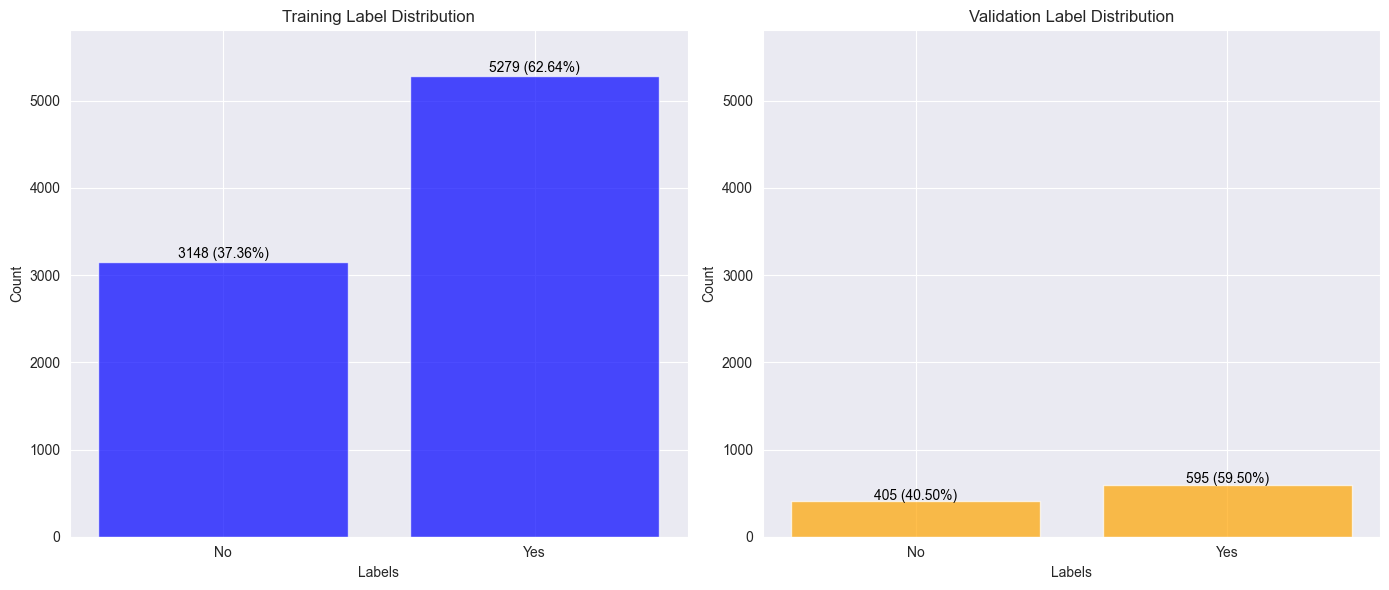

In [20]:
def plot_label_distribution_from_boolq(train_data, val_data):
    train_yes_count = sum(1 for label in train_data['answer'] if label == 1)
    train_no_count = sum(1 for label in train_data['answer'] if label == 0)
    val_yes_count = sum(1 for label in val_data['answer'] if label == 1)
    val_no_count = sum(1 for label in val_data['answer'] if label == 0)
    
    train_total = train_yes_count + train_no_count
    val_total = val_yes_count + val_no_count
    train_yes_percent = (train_yes_count / train_total) * 100
    train_no_percent = (train_no_count / train_total) * 100
    val_yes_percent = (val_yes_count / val_total) * 100
    val_no_percent = (val_no_count / val_total) * 100
    
    labels = ["No", "Yes"]
    train_counts = [train_no_count, train_yes_count]
    val_counts = [val_no_count, val_yes_count]
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].bar(labels, train_counts, color='blue', alpha=0.7)
    ax[0].set_title("Training Label Distribution")
    ax[0].set_xlabel("Labels")
    ax[0].set_ylabel("Count")
    ax[0].set_ylim(0, max(train_counts + val_counts) * 1.1)  # Consistent y-axis scale
    for i, v in enumerate(train_counts):
        ax[0].text(i, v + 50, f"{v} ({train_no_percent if i == 0 else train_yes_percent:.2f}%)", ha='center', color='black')
    
    ax[1].bar(labels, val_counts, color='orange', alpha=0.7)
    ax[1].set_title("Validation Label Distribution")
    ax[1].set_xlabel("Labels")
    ax[1].set_ylabel("Count")
    ax[1].set_ylim(0, max(train_counts + val_counts) * 1.1)  # Consistent y-axis scale
    for i, v in enumerate(val_counts):
        ax[1].text(i, v + 20, f"{v} ({val_no_percent if i == 0 else val_yes_percent:.2f}%)", ha='center', color='black')
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming train_data and validation_data are loaded datasets
plot_label_distribution_from_boolq(train_data, validation_data)

## Evaluation
The percentage of yes answers in each data split is: Train; 62.64%, Val; 59.50%, Test;62.17%
Seeing how difficult it was in past projects to reach a much better accuracy than the baseline majority class I am setting my goal for the transformer model at 64% accuracy on the test set.

### Metrics
**Accuracy**: To evaluate model performance across different hyperparameter configurations, I will use validation accuracy as the primary metric.
**Confusion Matrix**: This will give a comprehensive view of true positives, true negatives, false positives, and false negatives, allowing me deeper insight into the model’s performance.

### Error Analysis
To understand why the model may fail on certain predictions, I will conduct an error analysis investigating weather missclassifications are related to the confidence score the model has in it's predictions. Low confidence on correct answers or high confidence on wrong answers may indicate areas where the model is uncertain or overconfident.

## <span style="color: orange;">Evaluation</span>
Choosing to do without any manual preprocessing and relying on the built-in functionality of the AutoTokenizer module to handle padding, truncation, extra whitespace removal, special character removal and case sensitivity management was a success. Making the implementation more straightforward and reducing the potential for implementation errors. In most of my runs the transformer model would reach a validation accuracy of ~59%, after plotting the distribution of labels in the validation set it was clear to me the model is only predicting the majority "yes" class. After this realization I added the dropout layer and weight decay to the model which showed improvement in reaching a better validation accuracy, now reaching 60%. <br>
For my evaluation on the test set I chose the model reaching the highest accuracy on the validation set.
### Results of test set validation
Run name: emb_dim_256-n_heads_8-trans_h_dim_512-class_h_dim_128-dropout_0.2-lr_0.0001-warmup_100-w_decay_0.0001 <br>
Test Accuracy: 63.70%
True Positives: 1880
True Negatives: 203

The model reached an accuracy of 63.70% on the test set compared to the baseline of 62.17%, however it still predominantly predicts the majority class. 


In [21]:
# Define paths and load model from checkpoint
base_path = Path("checkpoints")
run_name = "emb_dim_256-n_heads_8-trans_h_dim_512-class_h_dim_128-dropout_0.2-lr_0.0001-warmup_100-w_decay_0.0001"
file_path = base_path / (run_name + ".ckpt")

# Load the model from the checkpoint
model = TransformerClassifier.load_from_checkpoint(file_path)
wandb_logger = WandbLogger(project="nlp_p3_transformer", name=run_name, group="evaluation")

# Initialize the trainer for testing
trainer = pl.Trainer(logger=wandb_logger)
trainer.test(model, test_loader)

# Finish WandB session
wandb.finish()

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

C:\Users\Pascal\AppData\Local\Temp\ipykernel_23712\1889658370.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids']) for item in batch]


Testing DataLoader 0: 100%|██████████| 52/52 [00:04<00:00, 12.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6370030641555786
        test_loss           0.6468071937561035
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁
test_accuracy,▁
test_loss,▁
trainer/global_step,▁▁
epoch,0
test_accuracy,0.637
test_loss,0.64681
trainer/global_step,0


## Interpretation
My expectation for this project are to beat the majority class baseline of 62.17% on the test set. My last project wasn't very successufl in that it only predicted the majority class every time. The feedback on that project was plenty and I hope I can improve on a lot of points for this project.

Given the results form the LSTM implementation I am setting my expecation for the Transformer architecture to reach an accuracy of 63% to 65% on the test set.
